In [1]:
import numpy as np
import gym
import matplotlib.pyplot as plt
%matplotlib inline

# TicTakToe ENV

In [2]:
N_ROWS, N_COLS, N_WIN = 3, 3, 3

In [3]:
class TicTacToe(gym.Env):
    def __init__(self, n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN, clone=None):
        if clone is not None:
            self.n_rows, self.n_cols, self.n_win = clone.n_rows, clone.n_cols, clone.n_win
            self.board = copy.deepcopy(clone.board)
            self.curTurn = clone.curTurn
            self.emptySpaces = None
            self.boardHash = None
        else:
            self.n_rows = n_rows
            self.n_cols = n_cols
            self.n_win = n_win

            self.reset()

    def getEmptySpaces(self):
        if self.emptySpaces is None:
            res = np.where(self.board == 0)
            self.emptySpaces = np.array([ (i, j) for i,j in zip(res[0], res[1]) ])
        return self.emptySpaces

    def makeMove(self, player, i, j):
        self.board[i, j] = player
        self.emptySpaces = None
        self.boardHash = None

    def getHash(self):
        if self.boardHash is None:
            self.boardHash = ''.join(['%s' % (x+1) for x in self.board.reshape(self.n_rows * self.n_cols)])
        return self.boardHash

    def isTerminal(self):
        # проверим, не закончилась ли игра
        cur_marks, cur_p = np.where(self.board == self.curTurn), self.curTurn
        for i,j in zip(cur_marks[0], cur_marks[1]):
            win = False
            if i <= self.n_rows - self.n_win:
                if np.all(self.board[i:i+self.n_win, j] == cur_p):
                    win = True
            if not win:
                if j <= self.n_cols - self.n_win:
                    if np.all(self.board[i,j:j+self.n_win] == cur_p):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j <= self.n_cols - self.n_win:
                    if np.all(np.array([ self.board[i+k,j+k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j >= self.n_win-1:
                    if np.all(np.array([ self.board[i+k,j-k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if win:
                self.gameOver = True
                return self.curTurn

        if len(self.getEmptySpaces()) == 0:
            self.gameOver = True
            return 0

        self.gameOver = False
        return None

    def printBoard(self):
        for i in range(0, self.n_rows):
            print('----'*(self.n_cols)+'-')
            out = '| '
            for j in range(0, self.n_cols):
                if self.board[i, j] == 1:
                    token = 'x'
                if self.board[i, j] == -1:
                    token = 'o'
                if self.board[i, j] == 0:
                    token = ' '
                out += token + ' | '
            print(out)
        print('----'*(self.n_cols)+'-')

    def getState(self):
        return (self.getHash(), self.getEmptySpaces(), self.curTurn)

    def action_from_int(self, action_int):
        return ( int(action_int / self.n_cols), int(action_int % self.n_cols))

    def int_from_action(self, action):
        return action[0] * self.n_cols + action[1]
    
    def step(self, action):
        if self.board[action[0], action[1]] != 0:
            return self.getState(), -10, True, {}
        self.makeMove(self.curTurn, action[0], action[1])
        reward = self.isTerminal()
        self.curTurn = -self.curTurn
        return self.getState(), 0 if reward is None else reward, reward is not None, {}

    def reset(self):
        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.boardHash = None
        self.gameOver = False
        self.emptySpaces = None
        self.curTurn = 1

In [4]:
def plot_board(env, pi, showtext=True, verbose=True, fontq=20, fontx=60):
    '''Рисуем доску с оценками из стратегии pi'''
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    X, Y = np.meshgrid(np.arange(0, env.n_rows), np.arange(0, env.n_rows))
    Z = np.zeros((env.n_rows, env.n_cols)) + .01
    s, actions = env.getHash(), env.getEmptySpaces()
    if pi is not None and s in pi.Q:
        for i, a in enumerate(actions):
            Z[a[0], a[1]] = pi.Q[s][i]
    ax.set_xticks([])
    ax.set_yticks([])
    surf = ax.imshow(Z, cmap=plt.get_cmap('Accent', 10), vmin=-1, vmax=1)
    if showtext:
        for i,a in enumerate(actions):
            if pi is not None and s in pi.Q:
                ax.text( a[1] , a[0] , "%.3f" % pi.Q[s][i], fontsize=fontq, horizontalalignment='center', verticalalignment='center', color="w" )
    for i in range(env.n_rows):
        for j in range(env.n_cols):
            if env.board[i, j] == -1:
                ax.text(j, i, "O", fontsize=fontx, horizontalalignment='center', verticalalignment='center', color="w" )
            if env.board[i, j] == 1:
                ax.text(j, i, "X", fontsize=fontx, horizontalalignment='center', verticalalignment='center', color="w" )
#     cbar = plt.colorbar(surf, ticks=[0, 1])
    ax.grid(False)
    plt.show()

def get_and_print_move(env, pi, s, actions, random=False, verbose=True, fontq=20, fontx=60):
    '''Делаем ход, рисуем доску'''
    plot_board(env, pi, fontq=fontq, fontx=fontx)
    if verbose and (pi is not None):
        if s in pi.Q:
            for i,a in enumerate(actions):
                print(i, a, pi.Q[s][i])
        else:
            print("Стратегия не знает, что делать...")
    if random:
        return np.random.randint(len(actions))
    else:
        return pi.getActionGreedy(s, len(actions))

In [5]:
def plot_test_game(env, pi1, pi2, random_crosses=False, random_naughts=True, verbose=True, fontq=20, fontx=60):
    '''Играем тестовую партию между стратегиями или со случайными ходами, рисуем ход игры'''
    done = False
    env.reset()
    while not done:
        s, actions = env.getHash(), env.getEmptySpaces()
        if env.curTurn == 1:
            a = get_and_print_move(env, pi1, s, actions, random=random_crosses, verbose=verbose, fontq=fontq, fontx=fontx)
        else:
            a = get_and_print_move(env, pi2, s, actions, random=random_naughts, verbose=verbose, fontq=fontq, fontx=fontx)
        observation, reward, done, info = env.step(actions[a])
        if reward == 1:
            print("Крестики выиграли!")
            plot_board(env, None, showtext=False, fontq=fontq, fontx=fontx)
        if reward == -1:
            print("Нолики выиграли!")
            plot_board(env, None, showtext=False, fontq=fontq, fontx=fontx)

In [6]:
class RandomAgent():
    def act(self, env):
        state = env.getState()
        move = np.random.choice(len(state[1]), 1)
        return state[1][move][0]

In [7]:
LF = 1e-3
DF = 1
EPS = -1

In [8]:
class QAgent():
    def __init__(self, p_id):
        self.p_id = p_id
        self.Q = dict()
        self.prev_s = None
        self.prev_a = None
        return
        
    def act(self, env):
        if self.prev_s != None:
            self.update(env, 0, False)
        state = env.getState()
        if state[0] not in self.Q.keys():
            act_array = [''.join(str(y) for y in x) for x in state[1]]
#             self.Q[state[0]] = {x: np.random.uniform(-LF * 0.1, LF * 0.1) for x in act_array}
            self.Q[state[0]] = {x: 0 for x in act_array}
            action = np.random.choice(act_array)
#             action = (int(action[0]), int(action[1]))
        else:
            if np.random.random() > EPS:
                vals = [x for x in self.Q[state[0]].values()]
#                 best_act = np.argmax([x for x in self.Q[state[0]].values()])
                best_act = np.random.choice(np.argwhere(vals == np.amax(vals)).flatten())
                action = [x for x in self.Q[state[0]].keys()][best_act]
#                 print(best_act, action)
            else:
#                 print("random")
                action = np.random.choice([x for x in self.Q[state[0]].keys()])
        self.prev_s = state[0]
        self.prev_a = action
#         print(action)
        return (int(action[0]), int(action[1]))
    
    def update(self, env, r, done):
        state = env.getState()
        if done:
            max_r = 0
        elif state[0] not in self.Q.keys():
            act_array = [''.join(str(y) for y in x) for x in state[1]]
#             self.Q[state[0]] = {x: np.random.uniform(-LF * 0.1, LF * 0.1) for x in act_array}
            self.Q[state[0]] = {x: 0 for x in act_array}
            max_r = 0
        else:
            if len(self.Q[state[0]].values()) > 0:
                max_r = np.max([x for x in self.Q[state[0]].values()])
            else:
                max_r = 0
        self.Q[self.prev_s][self.prev_a] += LF * (r * self.p_id + DF * max_r - self.Q[self.prev_s][self.prev_a])
        return

In [9]:
N_ROWS, N_COLS, N_WIN = 3, 3, 3
env = TicTacToe(N_ROWS, N_COLS, N_WIN)

In [17]:
agents = [QAgent(1), QAgent(-1)]
rewards = []
draws_arr = []
X_arr = []
O_arr = []

for j in range(50001):
    debug = (j % 10000 == 0)
    if debug:
        print("Play: ", j)
    env.reset()
    for i in range(100):
        action = agents[i % 2].act(env)
        state, reward, done, _ = env.step(action)
#         print(reward)
#         agents[i % 2].update(env, reward, done)
#         agents[(i + 1) % 2].update(env, reward)
        if done:
            agents[(i + 1) % 2].update(env, reward, done)
            rewards.append(reward)
#             print(reward)
            if debug:
                env.printBoard()
            break
        if debug:
            env.printBoard()
    if j % 1000 == 0 and j > 0:
        X_wins = sum(np.equal(rewards[-1000:], 1)) / 1000
        O_wins = sum(np.equal(rewards[-1000:], -1)) / 1000
        draws = sum(np.equal(rewards[-1000:], 0)) / 1000
        draws_arr.append(draws)
        X_arr.append(X_wins)
        O_arr.append(O_wins)
        print(X_wins, O_wins, draws)
#         print((len(rewards[-1000:]) - len(np.nonzero(rewards[-1000:])[0])) / len(rewards[-1000:]))

Play:  0
-------------
| x |   |   | 
-------------
|   |   |   | 
-------------
|   |   |   | 
-------------
-------------
| x |   |   | 
-------------
| o |   |   | 
-------------
|   |   |   | 
-------------
-------------
| x | x |   | 
-------------
| o |   |   | 
-------------
|   |   |   | 
-------------
-------------
| x | x |   | 
-------------
| o | o |   | 
-------------
|   |   |   | 
-------------
-------------
| x | x |   | 
-------------
| o | o |   | 
-------------
|   |   | x | 
-------------
-------------
| x | x |   | 
-------------
| o | o | o | 
-------------
|   |   | x | 
-------------
0.554 0.311 0.135
0.533 0.296 0.171
0.515 0.298 0.187
0.451 0.321 0.228
0.461 0.276 0.263
0.38 0.272 0.348
0.32 0.233 0.447
0.185 0.152 0.663
0.11 0.072 0.818
Play:  10000
-------------
|   |   | x | 
-------------
|   |   |   | 
-------------
|   |   |   | 
-------------
-------------
|   |   | x | 
-------------
|   | o |   | 
-------------
|   |   |   | 
-------------
-----------

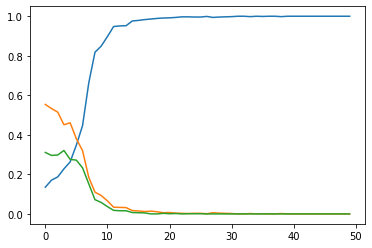

In [18]:
plt.plot(draws_arr)
plt.plot(X_arr)
plt.plot(O_arr)
plt.show()

# Примерно за 40 000 игр происходит обучение до оптимальной стратегии. Игра заканчивается в ничью.

# Поле 4х4 до 4-х в ряд

In [19]:
N_ROWS, N_COLS, N_WIN = 4, 4, 4
env = TicTacToe(N_ROWS, N_COLS, N_WIN)

In [20]:
agents = [QAgent(1), QAgent(-1)]
rewards = []
draws_arr = []
X_arr = []
O_arr = []

for j in range(5000000):
    debug = (j % 100000 == 0)
    if debug:
        print("Play: ", j)
    env.reset()
    for i in range(100):
        action = agents[i % 2].act(env)
        state, reward, done, _ = env.step(action)
#         print(reward)
#         agents[i % 2].update(env, reward, done)
#         agents[(i + 1) % 2].update(env, reward)
        if done:
            agents[(i + 1) % 2].update(env, reward, done)
            rewards.append(reward)
#             print(reward)
#             if debug:
#                 env.printBoard()
            break
#         if debug:
#             env.printBoard()
    if j % 100000 == 0 and j > 0:
        X_wins = sum(np.equal(rewards[-100000:], 1)) / 100000
        O_wins = sum(np.equal(rewards[-100000:], -1)) / 100000
        draws = sum(np.equal(rewards[-100000:], 0)) / 100000
        draws_arr.append(draws)
        X_arr.append(X_wins)
        O_arr.append(O_wins)
        print(X_wins, O_wins, draws)
#         print((len(rewards[-1000:]) - len(np.nonzero(rewards[-1000:])[0])) / len(rewards[-1000:]))

Play:  0
Play:  100000
0.31649 0.26249 0.42102
Play:  200000
0.31768 0.25196 0.43036
Play:  300000
0.32109 0.24385 0.43506
Play:  400000
0.31913 0.23836 0.44251
Play:  500000
0.32151 0.22953 0.44896
Play:  600000
0.31784 0.22589 0.45627
Play:  700000
0.31833 0.21836 0.46331
Play:  800000
0.31924 0.21588 0.46488
Play:  900000
0.31962 0.21209 0.46829
Play:  1000000
0.31635 0.21038 0.47327
Play:  1100000
0.31462 0.20861 0.47677
Play:  1200000
0.31675 0.20351 0.47974
Play:  1300000
0.31234 0.2035 0.48416
Play:  1400000
0.31129 0.20202 0.48669
Play:  1500000
0.31023 0.19884 0.49093
Play:  1600000
0.30806 0.19889 0.49305
Play:  1700000
0.30441 0.19766 0.49793
Play:  1800000
0.30732 0.1947 0.49798
Play:  1900000
0.30445 0.19585 0.4997
Play:  2000000
0.30094 0.1936 0.50546
Play:  2100000
0.2988 0.19512 0.50608
Play:  2200000
0.29892 0.19418 0.5069
Play:  2300000
0.29361 0.19419 0.5122
Play:  2400000
0.29425 0.19333 0.51242
Play:  2500000
0.2901 0.19391 0.51599
Play:  2600000
0.28915 0.19264 0.

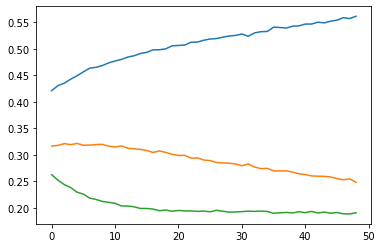

In [21]:
plt.plot(draws_arr)
plt.plot(X_arr)
plt.plot(O_arr)
plt.show()

## Игра до 4-х ничейная. Дальше у меня не учится - не хватает памяти для состояний.

# Поле 4х4 до 3-х в ряд

In [22]:
N_ROWS, N_COLS, N_WIN = 4, 4, 3
env = TicTacToe(N_ROWS, N_COLS, N_WIN)

In [23]:
agents = [QAgent(1), QAgent(-1)]
rewards = []
draws_arr = []
X_arr = []
O_arr = []

for j in range(5000000):
    debug = (j % 100000 == 0)
    if debug:
        print("Play: ", j)
    env.reset()
    for i in range(100):
        action = agents[i % 2].act(env)
        state, reward, done, _ = env.step(action)
#         print(reward)
#         agents[i % 2].update(env, reward, done)
#         agents[(i + 1) % 2].update(env, reward)
        if done:
            agents[(i + 1) % 2].update(env, reward, done)
            rewards.append(reward)
#             print(reward)
#             if debug:
#                 env.printBoard()
            break
#         if debug:
#             env.printBoard()
    if j % 100000 == 0 and j > 0:
        X_wins = sum(np.equal(rewards[-100000:], 1)) / 100000
        O_wins = sum(np.equal(rewards[-100000:], -1)) / 100000
        draws = sum(np.equal(rewards[-100000:], 0)) / 100000
        draws_arr.append(draws)
        X_arr.append(X_wins)
        O_arr.append(O_wins)
        print(X_wins, O_wins, draws)
#         print((len(rewards[-1000:]) - len(np.nonzero(rewards[-1000:])[0])) / len(rewards[-1000:]))

Play:  0
Play:  100000
0.58761 0.41102 0.00137
Play:  200000
0.58921 0.40891 0.00188
Play:  300000
0.5721 0.42539 0.00251
Play:  400000
0.57396 0.42363 0.00241
Play:  500000
0.57183 0.42568 0.00249
Play:  600000
0.5714 0.42619 0.00241
Play:  700000
0.56274 0.43408 0.00318
Play:  800000
0.58183 0.41395 0.00422
Play:  900000
0.59451 0.40211 0.00338
Play:  1000000
0.60105 0.39525 0.0037
Play:  1100000
0.61063 0.38555 0.00382
Play:  1200000
0.60783 0.38804 0.00413
Play:  1300000
0.61313 0.38176 0.00511
Play:  1400000
0.61675 0.37816 0.00509
Play:  1500000
0.62003 0.3744 0.00557
Play:  1600000
0.6209 0.37324 0.00586
Play:  1700000
0.62332 0.37059 0.00609
Play:  1800000
0.62985 0.36339 0.00676
Play:  1900000
0.62975 0.36353 0.00672
Play:  2000000
0.62942 0.36232 0.00826
Play:  2100000
0.63318 0.35786 0.00896
Play:  2200000
0.63534 0.35585 0.00881
Play:  2300000
0.63716 0.35383 0.00901
Play:  2400000
0.63811 0.34994 0.01195
Play:  2500000
0.64088 0.34755 0.01157
Play:  2600000
0.64341 0.34334

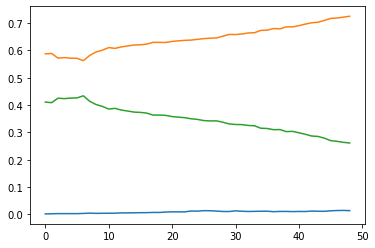

In [24]:
plt.plot(draws_arr)
plt.plot(X_arr)
plt.plot(O_arr)
plt.show()

## А здесь побеждают крестики